In [214]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms

from bounds import *
import dgp
from vset import *
import estimation, utils, experiments, vset, plots
import pandas as pd



In [215]:
Dx, Du = 5, 0
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    't_coeffs': 4*np.random.rand(nD) - 3,
    'lambda': 2,
    'model': 'LR'
}

msm_dgp = set_dgp_config(dgp, 'MSM')
data = generate_data(msm_dgp)


## Set up and check the DR estimator 

In [3]:
def compute_dr_vstat(D, T, Y, e, p_pi, mu, t):
    
    # Our target is conditional on D=0
    e = 1-e
    
    # Estimate our target conditional on T=t
    if t==0:
        T = 1-T
        p_pi=1-p_pi
    
    return (D*Y*p_pi + (T-p_pi)*e*mu).mean()


In [4]:
in_folds, out_folds = utils.k_fold_split_and_complement(data, 2)

fold_bdfs = []
    
k = 0

# Set-up datasets for fold K
in_data, out_data = in_folds[k], out_folds[k]
in_dgp, out_dgp = dgp.copy(), dgp.copy()
in_dgp['N'] = in_data['XU'].shape[0]
out_dgp['N'] = out_data['XU'].shape[0]

# Learn models, then run inference on data from fold k
in_probs = estimation.plugin_nuisance_probs(in_dgp, out_dgp, in_data, out_data)

outcome regression error: 0.01732683245120919
propensitiy error: 0.00923759840050364


In [7]:
compute_msm_bounds(in_dgp, in_data, in_probs)

(array([[0.05530199, 0.05945899],
        [0.05530199, 0.05945899]]),
 array([[0.19592636, 0.21766299],
        [0.19592636, 0.21766299]]))

In [172]:
vset.compute_msm_bounds(in_dgp, in_data, in_probs)

(array([[0.06857647, 0.05076113],
        [0.06857647, 0.05076113]]),
 array([[0.22291387, 0.18910887],
        [0.22291387, 0.18910887]]))

## Test learning outcome probabilities

In [10]:
msm_dgp = set_dgp_config(dgp, 'MSM')
data = generate_data(msm_dgp)
estimation.estimate_bounds(msm_dgp, data, id_method='MSM', est_method='plugin', K=5)

outcome regression error: 0.02013983540917368
propensitiy error: 0.011775164628989615

test that we successfully recovered probs
{'p_mu1': array([0.78983009, 0.47836741, 0.37013748, ..., 0.51350351, 0.32027526,
       0.53024059]), 'p_e1': array([0.71973738, 0.3716978 , 0.53640822, ..., 0.78082757, 0.42271087,
       0.44882485]), 'p_mu1_z': array([[0.7946301 , 0.48148691, 0.3759837 , ..., 0.52078541, 0.32027526,
        0.53231546],
       [0.79394939, 0.4804469 , 0.37500677, ..., 0.5197456 , 0.31936899,
        0.53127816],
       [0.79326701, 0.47940707, 0.37403085, ..., 0.51870563, 0.31846409,
        0.53024059],
       ...,
       [0.78983009, 0.47421074, 0.36916675, ..., 0.51350351, 0.31396018,
        0.52504898],
       [0.7891377 , 0.47317211, 0.36819708, ..., 0.51246269, 0.31306355,
        0.52400997],
       [0.78844363, 0.47213371, 0.36722847, ..., 0.51142177, 0.31216832,
        0.52297076]]), 'p_e1_z': array([[0.70737124, 0.36566205, 0.52348937, ..., 0.77029667, 0.42271

,Rs_down,Rs_up,Rd_down,Rd_up,Rs_coverage,Rd_coverage,R_oracle,metric,id_method,est_method
0,-0.304263,0.305681,-0.164913,0.212961,1.0,1.0,0.165257,m_y=1,MSM,plugin
1,-0.337924,0.265267,-0.211597,0.171656,0.0,0.0,-0.359006,m_y=0,MSM,plugin
2,-0.478055,0.435487,-0.199922,0.157354,1.0,0.0,0.231652,m_a=0,MSM,plugin
3,-0.115618,0.237098,-0.115618,0.237098,0.8,0.8,0.229071,m_a=1,MSM,plugin
4,-0.295290,0.335290,-0.155723,0.195723,1.0,0.0,0.228400,m_u,MSM,plugin


In [84]:
estimation.estimate_bounds(msm_dgp, data, id_method='MSM', est_method='plugin', K=5)

outcome regression error: 0.043218950581498154
propensitiy error: 0.026068173306555392
outcome regression error: 0.03883126286322675
propensitiy error: 0.025846728054586564
outcome regression error: 0.04162230822009172
propensitiy error: 0.024802039095536528
outcome regression error: 0.039635756080474094
propensitiy error: 0.02578407892389513
outcome regression error: 0.03992138284299188
propensitiy error: 0.025476313405033636


,Rs_down,Rs_up,Rd_down,Rd_up,Rs_coverage,Rd_coverage,R_oracle,metric,id_method,est_method
0,-0.545193,-0.338356,-0.508254,-0.377225,1.0,1.0,-0.449353,m_y=1,MSM,plugin
1,-0.550948,-0.342820,-0.514499,-0.381328,1.0,1.0,-0.458090,m_y=0,MSM,plugin
2,-0.280651,0.218070,-0.195899,0.133319,1.0,1.0,0.001760,m_a=0,MSM,plugin
3,-0.027843,0.057846,-0.027843,0.057846,1.0,1.0,0.007186,m_a=1,MSM,plugin
4,-0.084671,0.085471,-0.028803,0.029603,1.0,1.0,0.002100,m_u,MSM,plugin


# Coverage sample size experiment 
- Construct 95% bootstrap CI around plug-in estimates of the regret. Plot as a function of sample size.
- Also plot coverage as a function of sample size.

In [197]:
def get_est_exp_metadata(coveragedf, Ns):

    metrics = ['m_y=1', 'm_y=0', 'm_a=0', 'm_a=1', 'm_u']
    N_results = {
        'R_oracle': [],
        'Rd_up_oracle': [],
        'Rd_up_pl_mean': [],
        'Rd_up_pl_ci': [],
        'Rd_up_dr_mean': [],
        'Rd_up_dr_ci': [],
        'Rd_down_oracle': [],
        'Rd_down_pl_mean': [],
        'Rd_down_pl_ci': [],
        'Rd_down_dr_mean': [],
        'Rd_down_dr_ci': [],
        'N': [],
        'metric': [],
    }

    for n in Ns:
        for metric in metrics:

            oracle = coveragedf[(coveragedf['metric'] == metric) & (coveragedf['N'] == n) & (coveragedf['method'] == 'oracle')]
            plugin = coveragedf[(coveragedf['metric'] == metric) & (coveragedf['N'] == n) & (coveragedf['method'] == 'plugin')]
            dr = coveragedf[(coveragedf['metric'] == metric) & (coveragedf['N'] == n) & (coveragedf['method'] == 'dr')]

            plvals_up = plugin['Rd_up'].tolist()
            pl_ci_up = sms.DescrStatsW(plvals_up).tconfint_mean()
            pl_plvals_down = plugin['Rd_down'].tolist()
            pl_ci_down = sms.DescrStatsW(pl_plvals_down).tconfint_mean()

            drvals_up = dr['Rd_up'].tolist()
            dr_ci_up = sms.DescrStatsW(drvals_up).tconfint_mean()
            dr_plvals_down = dr['Rd_down'].tolist()
            dr_ci_down = sms.DescrStatsW(dr_plvals_down).tconfint_mean()

            N_results['R_oracle'].append(oracle['R_oracle'].mean())
            N_results['Rd_up_oracle'].append(oracle['Rd_up'].mean())
            N_results['Rd_up_pl_mean'].append(plugin['Rd_up'].mean())
            N_results['Rd_up_dr_mean'].append(dr['Rd_up'].mean())
            N_results['Rd_up_pl_ci'].append(pl_ci_up[1]-pl_ci_up[0])
            N_results['Rd_up_dr_ci'].append(dr_ci_up[1]-dr_ci_up[0])

            N_results['Rd_down_oracle'].append(oracle['Rd_down'].mean())
            N_results['Rd_down_pl_mean'].append(plugin['Rd_down'].mean())
            N_results['Rd_down_dr_mean'].append(dr['Rd_down'].mean())
            N_results['Rd_down_pl_ci'].append(pl_ci_down[1]-pl_ci_down[0])
            N_results['Rd_down_dr_ci'].append(dr_ci_down[1]-dr_ci_down[0])
            N_results['N'].append(n)
            N_results['metric'].append(metric)
            
    return pd.DataFrame(N_results)

In [203]:
Dx, Du = 5, 2
nD = Dx+Du

dgp = {
    'N': 20000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    't_coeffs': 4*np.random.rand(nD) - 3,
    'lambda': 1.5,
    'model': 'GB',
}

msm_dgp = set_dgp_config(dgp, 'MSM')
Ns = [100, 200, 300, 1500, 2000, 2500, 3000, 3500, 4000, msm_dgp['N']-1]
coveragedf = experiments.estimation_coverage_experiment(msm_dgp, Ns, Nsims=10)


outcome regression error: 0.25475602854119506
propensitiy error: 0.36084068730086194
outcome regression error: 0.3864040021249504
propensitiy error: 0.32744279692343947
outcome regression error: 0.38453578491445517
propensitiy error: 0.3400877573735004
outcome regression error: 0.3838694267464518
propensitiy error: 0.3404250284034507
outcome regression error: 0.34431236511666075
propensitiy error: 0.31490912510141755
outcome regression error: 0.3352941824856
propensitiy error: 0.2959756123990629
outcome regression error: 0.45609494963868735
propensitiy error: 0.3235506250888685
outcome regression error: 0.42960595341342167
propensitiy error: 0.28538232203470904
outcome regression error: 0.4504943480518893
propensitiy error: 0.2716720745933653
outcome regression error: 0.41675423366096637
propensitiy error: 0.28933584469630425
outcome regression error: 0.38877305687299835
propensitiy error: 0.349114948795238
outcome regression error: 0.33005189125525114
propensitiy error: 0.311642230229

outcome regression error: 0.3945027055889564
propensitiy error: 0.298100122458807
outcome regression error: 0.23353127349831979
propensitiy error: 0.13147597018025153
outcome regression error: 0.22388055540599347
propensitiy error: 0.1457297622632634
outcome regression error: 0.25875764797836986
propensitiy error: 0.14205853384089415
outcome regression error: 0.2627915094927337
propensitiy error: 0.13586724143775655
outcome regression error: 0.24336490514548104
propensitiy error: 0.1405278674027263
outcome regression error: 0.2196893157115419
propensitiy error: 0.15562069457945774
outcome regression error: 0.27989674786466007
propensitiy error: 0.136012207446846
outcome regression error: 0.2705849911833945
propensitiy error: 0.1412603489388706
outcome regression error: 0.278542780306786
propensitiy error: 0.13912730664656234
outcome regression error: 0.23958154694646278
propensitiy error: 0.1272994158023378
outcome regression error: 0.22239318581010456
propensitiy error: 0.129878982034

outcome regression error: 0.19867749922931072
propensitiy error: 0.16708977178491627
outcome regression error: 0.22559371928943986
propensitiy error: 0.16036781185142018
outcome regression error: 0.21284578089634912
propensitiy error: 0.17430675162291404
outcome regression error: 0.1803938684189447
propensitiy error: 0.11481467458995535
outcome regression error: 0.19023040397713756
propensitiy error: 0.12324213362236038
outcome regression error: 0.17935827344858993
propensitiy error: 0.12786225283541788
outcome regression error: 0.17830581816952512
propensitiy error: 0.11678945340145486
outcome regression error: 0.19672361149440884
propensitiy error: 0.11963861126457623
outcome regression error: 0.15849057065073846
propensitiy error: 0.10924271781289675
outcome regression error: 0.1958618317383192
propensitiy error: 0.14032811700733455
outcome regression error: 0.19595177947488565
propensitiy error: 0.10643511276004304
outcome regression error: 0.21654652423012222
propensitiy error: 0.

outcome regression error: 0.19046149043232802
propensitiy error: 0.11621191770933702
outcome regression error: 0.17530734081877636
propensitiy error: 0.12205557730186652
outcome regression error: 0.17783556373690534
propensitiy error: 0.12303394020762436
outcome regression error: 0.19037643179270838
propensitiy error: 0.10640952744789356
outcome regression error: 0.1945910277104754
propensitiy error: 0.11948014325690398
outcome regression error: 0.19223257078765077
propensitiy error: 0.1083434772395567
outcome regression error: 0.16969682000699285
propensitiy error: 0.10919067500258421
outcome regression error: 0.1763941708815271
propensitiy error: 0.09947731884917263
outcome regression error: 0.17712737839087525
propensitiy error: 0.1025422440912769
outcome regression error: 0.159041625257692
propensitiy error: 0.0977047414945368
outcome regression error: 0.1603040347018804
propensitiy error: 0.0963094904484572
outcome regression error: 0.16760461604214436
propensitiy error: 0.1145535

outcome regression error: 0.15139673631869088
propensitiy error: 0.10344505593553927
outcome regression error: 0.15970509341129158
propensitiy error: 0.09422603356835846
outcome regression error: 0.1669304448451408
propensitiy error: 0.08821287920018857
outcome regression error: 0.15869878422656306
propensitiy error: 0.10498329264967987
outcome regression error: 0.16127288859289904
propensitiy error: 0.11497975454782766
outcome regression error: 0.15028442770474412
propensitiy error: 0.10035234659966027
outcome regression error: 0.16231956060626757
propensitiy error: 0.10211040136842425
outcome regression error: 0.16109389088193637
propensitiy error: 0.0812938531021391
outcome regression error: 0.15118279800903106
propensitiy error: 0.08193301957081094
outcome regression error: 0.14610905948122402
propensitiy error: 0.0883668083299127
outcome regression error: 0.14270168719005366
propensitiy error: 0.08790569385570145
outcome regression error: 0.15597363496528577
propensitiy error: 0.0

outcome regression error: 0.13610483126626932
propensitiy error: 0.09474354503714709
outcome regression error: 0.1511544758285998
propensitiy error: 0.089341317818351
outcome regression error: 0.15090901694153624
propensitiy error: 0.1028849349582996
outcome regression error: 0.15326702882119514
propensitiy error: 0.09150611687093053
outcome regression error: 0.15789715590296965
propensitiy error: 0.09360126545333973
outcome regression error: 0.14750742388776902
propensitiy error: 0.09243692234593404
outcome regression error: 0.1565230941566446
propensitiy error: 0.08950201576194626
outcome regression error: 0.14649137690438008
propensitiy error: 0.09106428789567005
outcome regression error: 0.1426921769611636
propensitiy error: 0.08726635455027137
outcome regression error: 0.15291655029517084
propensitiy error: 0.08556438805227681
outcome regression error: 0.15586548339199838
propensitiy error: 0.09506543477587044
outcome regression error: 0.14210441093875312
propensitiy error: 0.0849

outcome regression error: 0.15540671331192576
propensitiy error: 0.08661596418343058
outcome regression error: 0.14617283768964234
propensitiy error: 0.08679173975892371
outcome regression error: 0.1372711209438948
propensitiy error: 0.07561976659855878
outcome regression error: 0.14886469872441466
propensitiy error: 0.08000397209727975
outcome regression error: 0.1399233817134571
propensitiy error: 0.08260586403216498
outcome regression error: 0.14169766666938682
propensitiy error: 0.0794367043024967
outcome regression error: 0.14376570303838132
propensitiy error: 0.07730415301937249
outcome regression error: 0.1405297764680597
propensitiy error: 0.07945746701265392
outcome regression error: 0.1409005948728854
propensitiy error: 0.08225085109444774
outcome regression error: 0.13699633178250645
propensitiy error: 0.08110469069105619
outcome regression error: 0.14140945352849754
propensitiy error: 0.07523279241829195
outcome regression error: 0.1391997550338598
propensitiy error: 0.0788

outcome regression error: 0.1364672151698445
propensitiy error: 0.07836558949068907
outcome regression error: 0.145502487999487
propensitiy error: 0.0812706883012672
outcome regression error: 0.13809048465418058
propensitiy error: 0.0793467072305941
outcome regression error: 0.14799179057284198
propensitiy error: 0.07576470628348698
outcome regression error: 0.14132916240808965
propensitiy error: 0.07377871148444252
outcome regression error: 0.14510857221110668
propensitiy error: 0.07650505352626653
outcome regression error: 0.15112174360845662
propensitiy error: 0.08029400026120632
outcome regression error: 0.1401843363961601
propensitiy error: 0.08291226697159298
outcome regression error: 0.1424494531908496
propensitiy error: 0.07958842333035973
outcome regression error: 0.1396146818954792
propensitiy error: 0.07644908216853177
outcome regression error: 0.12994962836131682
propensitiy error: 0.07720704272065838
outcome regression error: 0.13908946308808676
propensitiy error: 0.079732

outcome regression error: 0.1384793096597619
propensitiy error: 0.07200449570434125
outcome regression error: 0.13821647778318638
propensitiy error: 0.07339670932046746
outcome regression error: 0.14211286503124776
propensitiy error: 0.07603746390695579
outcome regression error: 0.13285718121627133
propensitiy error: 0.06859484797139175
outcome regression error: 0.1452407255467798
propensitiy error: 0.07372525944423448
outcome regression error: 0.13933305347529795
propensitiy error: 0.07158198091666043
outcome regression error: 0.14133266028849192
propensitiy error: 0.07210124484176202
outcome regression error: 0.1408649871134062
propensitiy error: 0.07698644466887053
outcome regression error: 0.14385849063108783
propensitiy error: 0.07296770647043584
outcome regression error: 0.13687313195861783
propensitiy error: 0.07164676180739822
outcome regression error: 0.13385144936658477
propensitiy error: 0.07554397123862687
outcome regression error: 0.1402682350763168
propensitiy error: 0.07

outcome regression error: 0.13046548941814978
propensitiy error: 0.07244896440681461
outcome regression error: 0.1348748498065598
propensitiy error: 0.07084352745550503
outcome regression error: 0.14059827676697575
propensitiy error: 0.06936540770998904
outcome regression error: 0.13246238790628925
propensitiy error: 0.06939050805675227
outcome regression error: 0.12793681895618467
propensitiy error: 0.06674549312922622
outcome regression error: 0.13382288714184895
propensitiy error: 0.06785872073981382
outcome regression error: 0.13662626281905133
propensitiy error: 0.07112304877346291
outcome regression error: 0.13198852363164634
propensitiy error: 0.07250144682620623
outcome regression error: 0.13475419088984283
propensitiy error: 0.07155627675403846
outcome regression error: 0.1281165094781026
propensitiy error: 0.06795162912692762
outcome regression error: 0.13356492954379248
propensitiy error: 0.06990036667646819
outcome regression error: 0.13277419207502114
propensitiy error: 0.

outcome regression error: 0.11578600043876662
propensitiy error: 0.051932159229161126
outcome regression error: 0.11523499690931839
propensitiy error: 0.05068690663306955
outcome regression error: 0.11684831235861752
propensitiy error: 0.050424770207899615
outcome regression error: 0.1140204802620072
propensitiy error: 0.05141543322511464
outcome regression error: 0.11374383392923798
propensitiy error: 0.05121289593314681
outcome regression error: 0.11442167124717306
propensitiy error: 0.051794853753132704
outcome regression error: 0.1145612026375042
propensitiy error: 0.05121341797636175
outcome regression error: 0.11415893336537863
propensitiy error: 0.0506492760656286
outcome regression error: 0.11135860921840747
propensitiy error: 0.05161560275474025
outcome regression error: 0.11522763987975601
propensitiy error: 0.05187842107741138
outcome regression error: 0.11597242459374031
propensitiy error: 0.05131984801965396
outcome regression error: 0.11568228802969097
propensitiy error: 

In [206]:
ns_data = get_est_exp_metadata(coveragedf, Ns)
ns_data = ns_data[ns_data['metric'] == 'm_u']

oracle_up = ns_data['Rd_up_oracle'].tolist()[-1]
oracle_down = ns_data['Rd_down_oracle'].tolist()[-1]
coveragedf['Rd_up_error'] = (coveragedf['Rd_up'] - oracle_up)**2
coveragedf['Rd_down_error'] = (coveragedf['Rd_down'] - oracle_down)**2
coveragedf = coveragedf[coveragedf['method'] != 'oracle']

def get_key_df(coveragedf, error_col):
    msedf = coveragedf.groupby(['N','method']).mean()[error_col].reset_index()
    msedf = msedf.pivot(index='N', columns='method', values=error_col).reset_index()
    msedf.columns.name = None
    return msedf.iloc[:-1]

In [211]:
get_key_df(coveragedf, 'Rd_up_error')

,N,dr,plugin
0,100,0.018469,0.012868
1,500,0.004035,0.001783
2,1000,0.002766,0.001497
3,1500,0.003504,0.001423
4,2000,0.002220,0.001159
5,2500,0.002391,0.000999
6,3000,0.003033,0.001312
7,3500,0.002113,0.001627
8,4000,0.002534,0.001299


In [212]:
get_key_df(coveragedf, 'Rd_down_error')

,N,dr,plugin
0,100,0.015065,0.012036
1,500,0.004067,0.001940
2,1000,0.002956,0.001768
3,1500,0.003058,0.001366
4,2000,0.002275,0.001010
5,2500,0.002555,0.000810
6,3000,0.002825,0.001040
7,3500,0.001906,0.001294
8,4000,0.002282,0.001047


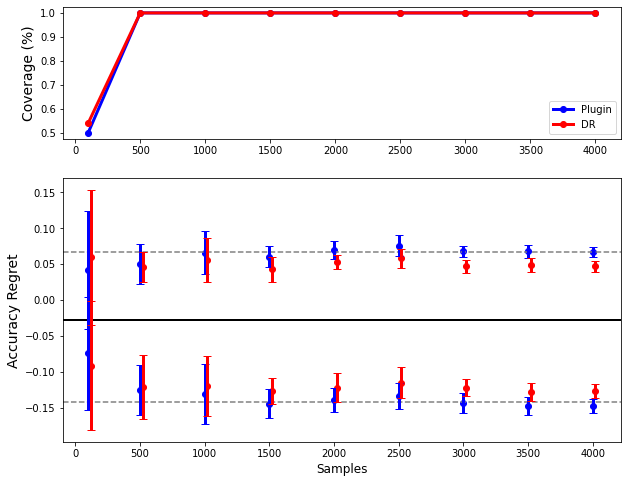

In [213]:

oracle = ns_data['R_oracle'].tolist()[-1]
ns_data = ns_data.iloc[:-1,:]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [1,2]})

# Filter to estimation methods
cdf = coveragedf[(coveragedf['metric'] == 'm_u')]
pl_data = cdf[(cdf['est_method'] == 'plugin')]
dr_data = cdf[(cdf['est_method'] == 'dr')]
oracle_data = cdf[(cdf['est_method'] == 'oracle')]

# Compute coverage
oracle_coverage = oracle_data.groupby('N').mean()['Rd_coverage'].tolist()[:-1]
pl_coverage = pl_data.groupby('N').mean()['Rd_coverage'].tolist()[:-1]
dr_coverage = dr_data.groupby('N').mean()['Rd_coverage'].tolist()[:-1]

# Create coverage plot
N = coveragedf.groupby('N').mean().reset_index()['N'].tolist()[:-1]
ax1.plot(N, pl_coverage, marker='o', color='b', linewidth=3, label='Plugin')
ax1.plot(N, dr_coverage, marker='o', color='r', linewidth=3, label='DR')
ax1.set_ylabel('Coverage (%)', fontsize=14)
ax1.legend()

# Create interval estimation plot
ax2.axhline(oracle_up, color='grey', linestyle='--')
ax2.axhline(oracle_down, color='grey', linestyle='--')
ax2.axhline(oracle, color='k', linewidth=2,label='$R^*$')

ax2.scatter(ns_data['N'], ns_data['Rd_up_pl_mean'], color='blue')
ax2.scatter(ns_data['N']+20, ns_data['Rd_up_dr_mean'], color='red')
ax2.scatter(ns_data['N'], ns_data['Rd_down_pl_mean'], color='blue')
ax2.scatter(ns_data['N']+20, ns_data['Rd_down_dr_mean'], color='red')

for ix,n in enumerate(ns_data['N']):
    ax2.errorbar(n, ns_data['Rd_up_pl_mean'].tolist()[ix], yerr=ns_data['Rd_up_pl_ci'].tolist()[ix], 
                    capsize=4, linewidth=3, elinewidth=3, color='blue', label='pl')
                                                                 
    ax2.errorbar(n, ns_data['Rd_down_pl_mean'].tolist()[ix], yerr=ns_data['Rd_down_pl_ci'].tolist()[ix], 
                     capsize=4, linewidth=3, elinewidth=3, color='blue', label='pl')
    
    
    ax2.errorbar(n+20, ns_data['Rd_up_dr_mean'].tolist()[ix], yerr=ns_data['Rd_up_dr_ci'].tolist()[ix], 
                     capsize=4, linewidth=3, elinewidth=3, color='red', label='DR')
    

    ax2.errorbar(n+20, ns_data['Rd_down_dr_mean'].tolist()[ix], yerr=ns_data['Rd_down_dr_ci'].tolist()[ix], 
                     capsize=4, linewidth=3, elinewidth=3, color='red', label='DR')
    
     
x_loc = max(ns_data['N']) + 100  # Adjust the offset (10 here) as needed
# ax2.text(x_loc, oracle_up, '$\hat{R}_{\delta}$ (upper bound)', va='center', fontsize=12)
# ax2.text(x_loc, oracle_down, '$\hat{R}_{\delta}$ (lower bound)', va='center', clip_on=False, fontsize=12)
# ax2.text(x_loc, oracle, '$R^{*}$', va='center', fontsize=12)

ax2.set_xlabel('Samples', fontsize=12)
ax2.set_ylabel('Accuracy Regret', fontsize=14)
plt.savefig('figs/pl_estimation.pdf', dpi=500, bbox_inches='tight')



# Design sensitivity experiment 
- Delta bounds enable certifying a policy improvement up to a larger magnitude of confounding

In [183]:
Dx, Du = 5, 2
nD = Dx+Du


dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    't_coeffs': 4*np.random.rand(nD) - 3,
    'lambda': 1.5,
    'lambda_star': 1.1,
    'uniform_pi': True,
    'model': 'GB'
}

msm_dgp = set_dgp_config(dgp, 'MSM')
data = generate_data(msm_dgp)

outcome regression error: 0.06364557943271358
propensitiy error: 0.05440957597632088
outcome regression error: 0.06640826084815155
propensitiy error: 0.05512758374838222
outcome regression error: 0.06685287742086837
propensitiy error: 0.054522773365232056
outcome regression error: 0.06756063935394237
propensitiy error: 0.05212440103550335
outcome regression error: 0.06411463298318883
propensitiy error: 0.05515677065853794
outcome regression error: 0.06475030775922705
propensitiy error: 0.05452749576176744
outcome regression error: 0.06664605100160824
propensitiy error: 0.054142317986894964
outcome regression error: 0.06928929821014045
propensitiy error: 0.05513873309675847
outcome regression error: 0.06575772702395775
propensitiy error: 0.05485063010461864
outcome regression error: 0.06413945596912288
propensitiy error: 0.05627628887740885
outcome regression error: 0.06779687558274158
propensitiy error: 0.05453397200924728
outcome regression error: 0.06520122390306139
propensitiy error

outcome regression error: 0.06341916882645612
propensitiy error: 0.05383566530683255
outcome regression error: 0.06724475990033288
propensitiy error: 0.05625565048021443
outcome regression error: 0.06490912321784265
propensitiy error: 0.053224872698899986
outcome regression error: 0.06488295642871318
propensitiy error: 0.053837151939582134
outcome regression error: 0.06221155388033766
propensitiy error: 0.056809122126526446
outcome regression error: 0.0695245595429343
propensitiy error: 0.054451367836316794
outcome regression error: 0.06654717228783263
propensitiy error: 0.0538477973442111
outcome regression error: 0.06497364563957657
propensitiy error: 0.055526783779633916
outcome regression error: 0.06579027481764084
propensitiy error: 0.05467553048884515
outcome regression error: 0.06863635100525717
propensitiy error: 0.05315324236148241
outcome regression error: 0.06565250491529531
propensitiy error: 0.053181439749846376
outcome regression error: 0.0661948293976813
propensitiy erro

outcome regression error: 0.06380065215073966
propensitiy error: 0.05589801323296895
outcome regression error: 0.06531462646532442
propensitiy error: 0.055018541106797075
outcome regression error: 0.06343219483191899
propensitiy error: 0.05397829781880144
outcome regression error: 0.06641605401966294
propensitiy error: 0.05487760318376585
outcome regression error: 0.06658892013232685
propensitiy error: 0.05517569826975922
outcome regression error: 0.06330026965948471
propensitiy error: 0.05431100249540082
outcome regression error: 0.0641299904255709
propensitiy error: 0.053842846648847524
outcome regression error: 0.06214197625963962
propensitiy error: 0.053136890211897214
outcome regression error: 0.06680992275365141
propensitiy error: 0.05435880871790741
outcome regression error: 0.06480299140759939
propensitiy error: 0.056525022265316686
outcome regression error: 0.06396494536197611
propensitiy error: 0.05398571564679247
outcome regression error: 0.059166854305260905
propensitiy err

outcome regression error: 0.06479189042515233
propensitiy error: 0.0542035803420505
outcome regression error: 0.06473010264416103
propensitiy error: 0.05539357747100621
outcome regression error: 0.06574216512841234
propensitiy error: 0.05396500753902953
outcome regression error: 0.06797549301564877
propensitiy error: 0.056533161388873134
outcome regression error: 0.06338913568599233
propensitiy error: 0.05474646839850979
outcome regression error: 0.06431464994110046
propensitiy error: 0.05611337340571126
outcome regression error: 0.06546096926723388
propensitiy error: 0.057353814147449486
outcome regression error: 0.06287859969764133
propensitiy error: 0.054373702099876235
outcome regression error: 0.06724862315791871
propensitiy error: 0.054376547557441986
outcome regression error: 0.0651878321831062
propensitiy error: 0.056985880809096556
outcome regression error: 0.06673221450359787
propensitiy error: 0.058163729171787595
outcome regression error: 0.06756882994627435
propensitiy err

outcome regression error: 0.0669358703533406
propensitiy error: 0.05605686565511759
outcome regression error: 0.06332514142028332
propensitiy error: 0.05402938296696905
outcome regression error: 0.0640213457634867
propensitiy error: 0.05525762628308718
outcome regression error: 0.06482294169814475
propensitiy error: 0.05442219258503505
outcome regression error: 0.06403198669205008
propensitiy error: 0.0547813326837237
outcome regression error: 0.06489870351778881
propensitiy error: 0.05348539243431229
outcome regression error: 0.06506161471342847
propensitiy error: 0.05816323215228144
outcome regression error: 0.06729691796829226
propensitiy error: 0.05419398920263428
outcome regression error: 0.06490225703452555
propensitiy error: 0.05627664708694953
outcome regression error: 0.06328729091108731
propensitiy error: 0.05187886934364881
outcome regression error: 0.06276674144667409
propensitiy error: 0.05339554492797674
outcome regression error: 0.0670834291569234
propensitiy error: 0.05

outcome regression error: 0.06184681406887985
propensitiy error: 0.05413972257398348
outcome regression error: 0.06964466439038686
propensitiy error: 0.05297806509191607
outcome regression error: 0.06406179169535539
propensitiy error: 0.05446784516774969
outcome regression error: 0.06434762057670788
propensitiy error: 0.05453099724866583
outcome regression error: 0.06554187970014168
propensitiy error: 0.055153167357896424
outcome regression error: 0.0661563724284694
propensitiy error: 0.05552322758679448
outcome regression error: 0.06410262407990085
propensitiy error: 0.05606097505558169
outcome regression error: 0.06455257287120025
propensitiy error: 0.05363127578867333
outcome regression error: 0.061764209798278805
propensitiy error: 0.05581831339581254
outcome regression error: 0.06704839728390996
propensitiy error: 0.054235816903816375
outcome regression error: 0.0655564805989407
propensitiy error: 0.055361546593922194
outcome regression error: 0.06246174907902328
propensitiy error

outcome regression error: 0.06847816515448871
propensitiy error: 0.05745824717157345
outcome regression error: 0.0633130060730083
propensitiy error: 0.053226331788223204
outcome regression error: 0.06583359977211437
propensitiy error: 0.05414179146116344
outcome regression error: 0.06184205163950183
propensitiy error: 0.053023323583336245
outcome regression error: 0.06351612580936364
propensitiy error: 0.056402575528594956
outcome regression error: 0.06535603252850715
propensitiy error: 0.05444635822884246
outcome regression error: 0.06555290166263152
propensitiy error: 0.05561497285108591
outcome regression error: 0.0660861882589071
propensitiy error: 0.05668895184827914
outcome regression error: 0.06438312911797667
propensitiy error: 0.05730481860663014
outcome regression error: 0.06761305568730337
propensitiy error: 0.05324737503298644
outcome regression error: 0.06490608762081164
propensitiy error: 0.05370907578489244
outcome regression error: 0.06448856485574624
propensitiy error:

outcome regression error: 0.06243568470931869
propensitiy error: 0.05520695635698107
outcome regression error: 0.06441613789485598
propensitiy error: 0.05299950249627606
outcome regression error: 0.06405516304143447
propensitiy error: 0.056603766867161454
outcome regression error: 0.06644217219176493
propensitiy error: 0.053001123394937996
outcome regression error: 0.06392224302886508
propensitiy error: 0.054660003043832436
outcome regression error: 0.06513947820375976
propensitiy error: 0.056577048046348964
outcome regression error: 0.06528157204439561
propensitiy error: 0.05282942897178357
outcome regression error: 0.06768806068694985
propensitiy error: 0.052669465082084484
outcome regression error: 0.06582844455485315
propensitiy error: 0.05694800940110696
outcome regression error: 0.06542700566605594
propensitiy error: 0.05860417979869321
outcome regression error: 0.06258420251750821
propensitiy error: 0.05595996225203609
outcome regression error: 0.06551170975913487
propensitiy er

outcome regression error: 0.06469210562528571
propensitiy error: 0.05586295080526437
outcome regression error: 0.06585695519160083
propensitiy error: 0.05605324916825716
outcome regression error: 0.06308405116338098
propensitiy error: 0.053916413213433455
outcome regression error: 0.06339500934274471
propensitiy error: 0.055068022726466805
outcome regression error: 0.06105588250828348
propensitiy error: 0.05515429363315176
outcome regression error: 0.0632135177449647
propensitiy error: 0.051814399065831816
outcome regression error: 0.0679752920416047
propensitiy error: 0.05451523405966668
outcome regression error: 0.06888317634056809
propensitiy error: 0.05482321210192018
outcome regression error: 0.06525401497896613
propensitiy error: 0.0557492839720396
outcome regression error: 0.0634127335270402
propensitiy error: 0.05236381386872023
outcome regression error: 0.0685287824395587
propensitiy error: 0.05741562124456652
outcome regression error: 0.0603326147795708
propensitiy error: 0.0

outcome regression error: 0.06624474122511353
propensitiy error: 0.05366926138708765
outcome regression error: 0.06678232309307561
propensitiy error: 0.05285325208651572
outcome regression error: 0.06512428196483304
propensitiy error: 0.05380778785869218
outcome regression error: 0.06770217807620971
propensitiy error: 0.05481123074843387
outcome regression error: 0.06609002584935053
propensitiy error: 0.054666489186126474
outcome regression error: 0.0637057396103912
propensitiy error: 0.053892908566121174
outcome regression error: 0.06825392528688637
propensitiy error: 0.052289995499486853
outcome regression error: 0.06736183927025036
propensitiy error: 0.056202219584822376
outcome regression error: 0.06515849190853808
propensitiy error: 0.05561399364865176
outcome regression error: 0.06420054940373729
propensitiy error: 0.05448934156086151
outcome regression error: 0.06561292901437561
propensitiy error: 0.05450093047432695
outcome regression error: 0.0645817010430102
propensitiy error

outcome regression error: 0.06424297503113909
propensitiy error: 0.05389493513567289
outcome regression error: 0.06594545312101
propensitiy error: 0.05432564956795004
outcome regression error: 0.0658883206957116
propensitiy error: 0.0564033291153533
outcome regression error: 0.06502711673618786
propensitiy error: 0.055127446307702985
outcome regression error: 0.06366649334620163
propensitiy error: 0.05369950147702635
outcome regression error: 0.06580512260029371
propensitiy error: 0.05759136550551784
outcome regression error: 0.06822962859277436
propensitiy error: 0.05487650079977182
outcome regression error: 0.06398854937792786
propensitiy error: 0.05517955497101192
outcome regression error: 0.06552570795405935
propensitiy error: 0.05528962514367207
outcome regression error: 0.0634685329278578
propensitiy error: 0.05392123983073381
outcome regression error: 0.0680389684613023
propensitiy error: 0.0558049058243347
outcome regression error: 0.06350518829193401
propensitiy error: 0.05361

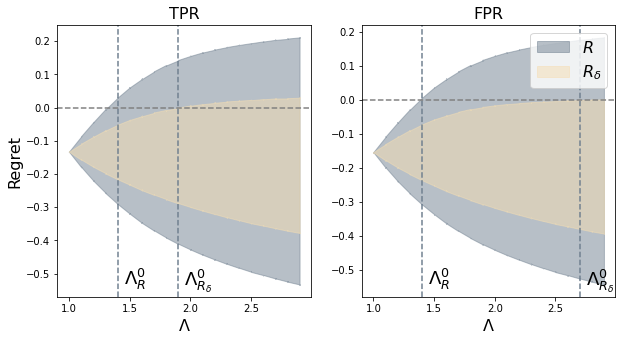

In [9]:
lambdas = np.arange(1, 3, .1)
brdf = experiments.design_sensitivity_exp(dgp, data, lambdas, n_sims=10)
plots.plot_design_sensitivity(brdf)

# Experiment: Exclusion restriction violation tests

outcome regression error: 0.02128225932823449
propensitiy error: 0.028069798352787136
outcome regression error: 0.019120937351952947
propensitiy error: 0.028180163596128422
outcome regression error: 0.01977979162596287
propensitiy error: 0.028168661727956852
outcome regression error: 0.020499034393112084
propensitiy error: 0.02779718486060573
outcome regression error: 0.019765759190650035
propensitiy error: 0.028355007143790377
outcome regression error: 0.020653071712181652
propensitiy error: 0.027665359647747714
outcome regression error: 0.02038735763108953
propensitiy error: 0.02869145555129657
outcome regression error: 0.02013003276352511
propensitiy error: 0.0281756849379803
outcome regression error: 0.021749817811318527
propensitiy error: 0.028527589070135796
outcome regression error: 0.0219455734869702
propensitiy error: 0.028310137209222687
outcome regression error: 0.019701099035064527
propensitiy error: 0.028542963534269803
outcome regression error: 0.019903234021302726
propen

outcome regression error: 0.019725638595634712
propensitiy error: 0.029299738207130516
outcome regression error: 0.01882884067283084
propensitiy error: 0.0287385195488353
outcome regression error: 0.018648369189730923
propensitiy error: 0.028572486798308823
outcome regression error: 0.018626542298370227
propensitiy error: 0.02891402922390141
outcome regression error: 0.019102241219338397
propensitiy error: 0.02883219601015947
outcome regression error: 0.01957271738520049
propensitiy error: 0.026839737787674282
outcome regression error: 0.019342996198275605
propensitiy error: 0.027368432379913987
outcome regression error: 0.021466976997045372
propensitiy error: 0.02761547359711422
outcome regression error: 0.01899487336280337
propensitiy error: 0.02647722671161807
outcome regression error: 0.019536876137371942
propensitiy error: 0.027057974366561835
outcome regression error: 0.021019236635990413
propensitiy error: 0.02817835446814951
outcome regression error: 0.019349934818969457
propen

outcome regression error: 0.021808439688483495
propensitiy error: 0.030164012173814266
outcome regression error: 0.021278964320957338
propensitiy error: 0.02960919562743517
outcome regression error: 0.021827293678755657
propensitiy error: 0.029516182572476794
outcome regression error: 0.02224485392362238
propensitiy error: 0.0292960425856501
outcome regression error: 0.022116871538164943
propensitiy error: 0.029722838647931852
outcome regression error: 0.019002158166503812
propensitiy error: 0.029306101467819125
outcome regression error: 0.02091552849982137
propensitiy error: 0.02955976219450288
outcome regression error: 0.019638536862293138
propensitiy error: 0.029236593022434205
outcome regression error: 0.018095881546299125
propensitiy error: 0.029308381225033705
outcome regression error: 0.02034783774513964
propensitiy error: 0.02956205689623323
outcome regression error: 0.02202012464887885
propensitiy error: 0.02856437660070279
outcome regression error: 0.02165440963432169
propens

outcome regression error: 0.0187812436473643
propensitiy error: 0.029113993720610264
outcome regression error: 0.01958531344575266
propensitiy error: 0.028763180731531383
outcome regression error: 0.01968981392344683
propensitiy error: 0.0287163358922717
outcome regression error: 0.020068233155742136
propensitiy error: 0.027913047179029284
outcome regression error: 0.019497125540641706
propensitiy error: 0.028745681570766422
outcome regression error: 0.019713842339086823
propensitiy error: 0.027939325378059876
outcome regression error: 0.019494919058858855
propensitiy error: 0.02833037687139923
outcome regression error: 0.018898298755861707
propensitiy error: 0.027731209018288766
outcome regression error: 0.01937704692658785
propensitiy error: 0.028267695300190077
outcome regression error: 0.020834011071785712
propensitiy error: 0.02921030265840506
outcome regression error: 0.020814588951345095
propensitiy error: 0.02920121619468615
outcome regression error: 0.022579607980226693
propen

outcome regression error: 0.020996256501938596
propensitiy error: 0.029561379513477974
outcome regression error: 0.020209874029286732
propensitiy error: 0.028809946424079306
outcome regression error: 0.022322981323297023
propensitiy error: 0.02905114647919083
outcome regression error: 0.02159668681885789
propensitiy error: 0.028220893297272794
outcome regression error: 0.020788445437550925
propensitiy error: 0.02862095909856794
outcome regression error: 0.01964542431206842
propensitiy error: 0.027772390145937784
outcome regression error: 0.01962111835290647
propensitiy error: 0.02893370455129045
outcome regression error: 0.01934230164489557
propensitiy error: 0.02874582857100801
outcome regression error: 0.01954770510761705
propensitiy error: 0.028702821024216195
outcome regression error: 0.019846901421235245
propensitiy error: 0.02860787437431183
outcome regression error: 0.0193827768212373
propensitiy error: 0.02848668635926254
outcome regression error: 0.018790047997958425
propensit

outcome regression error: 0.022806714588316488
propensitiy error: 0.028707405219859157
outcome regression error: 0.020126562925101205
propensitiy error: 0.029574068475086705
outcome regression error: 0.01996210821350853
propensitiy error: 0.028732250639665283
outcome regression error: 0.019831026755083882
propensitiy error: 0.02847300033825077
outcome regression error: 0.021664768247192774
propensitiy error: 0.027476794775419106
outcome regression error: 0.020240292674587504
propensitiy error: 0.02914903820455459
outcome regression error: 0.019997961106838033
propensitiy error: 0.02890920452956079
outcome regression error: 0.02057855048903472
propensitiy error: 0.029565914550190125
outcome regression error: 0.01871966356755133
propensitiy error: 0.028552392964862228
outcome regression error: 0.02071123785374713
propensitiy error: 0.0285111489552026
outcome regression error: 0.017887861654407797
propensitiy error: 0.027564976761291216
outcome regression error: 0.01807382408217688
propen

outcome regression error: 0.020558349989504534
propensitiy error: 0.027922264978615986
outcome regression error: 0.020241880367937407
propensitiy error: 0.028152560256558132
outcome regression error: 0.019967144534928337
propensitiy error: 0.028780743082784745
outcome regression error: 0.019400357434768825
propensitiy error: 0.028177574410940848
outcome regression error: 0.01997189060228063
propensitiy error: 0.028317522944604295
outcome regression error: 0.02083466308271786
propensitiy error: 0.028270443820105347
outcome regression error: 0.0196832051930203
propensitiy error: 0.02887462598337602
outcome regression error: 0.01914712138943225
propensitiy error: 0.02858875685590947
outcome regression error: 0.020199733513513656
propensitiy error: 0.027964495351568395
outcome regression error: 0.021140233337209217
propensitiy error: 0.0280837612643164
outcome regression error: 0.02134152533754462
propensitiy error: 0.02752559440899334
outcome regression error: 0.020779326015768124
propens

outcome regression error: 0.01845990427504646
propensitiy error: 0.0291954261746125
outcome regression error: 0.018573318992729935
propensitiy error: 0.028639548741591837
outcome regression error: 0.0188940335595827
propensitiy error: 0.028761152714106543
outcome regression error: 0.019150759111668258
propensitiy error: 0.02909021743990021
outcome regression error: 0.020478035171893175
propensitiy error: 0.029397580926116742
outcome regression error: 0.0186887567105361
propensitiy error: 0.028373111652776305
outcome regression error: 0.018373985294988182
propensitiy error: 0.02763869097548963
outcome regression error: 0.019079193731086342
propensitiy error: 0.02763930972350056
outcome regression error: 0.019770254267470807
propensitiy error: 0.028075346446387005
outcome regression error: 0.019359615826814353
propensitiy error: 0.02834057843332529
outcome regression error: 0.020034182469648172
propensitiy error: 0.02842002516504581
outcome regression error: 0.019877617527477083
propensi

outcome regression error: 0.019130144106988343
propensitiy error: 0.029608984347583567
outcome regression error: 0.018617495466032138
propensitiy error: 0.029757508235867938
outcome regression error: 0.02011029133538737
propensitiy error: 0.0289157116376647
outcome regression error: 0.01971709828272317
propensitiy error: 0.02957157822828193
outcome regression error: 0.020413085889878578
propensitiy error: 0.029169835969448835
outcome regression error: 0.01851839659402934
propensitiy error: 0.028266673342250817
outcome regression error: 0.019695365384024163
propensitiy error: 0.028736475906610173
outcome regression error: 0.01871342084871165
propensitiy error: 0.029917602039719864
outcome regression error: 0.020343173791011773
propensitiy error: 0.02823128898476527
outcome regression error: 0.02199736482292606
propensitiy error: 0.02817470283063654
outcome regression error: 0.024444271590169687
propensitiy error: 0.02958559813252957
outcome regression error: 0.02196548561752671
propensi

outcome regression error: 0.019099445293412582
propensitiy error: 0.02906686746488101
outcome regression error: 0.017119795961960633
propensitiy error: 0.028170892689762972
outcome regression error: 0.01779029319019292
propensitiy error: 0.02899062786041819
outcome regression error: 0.017675102181508646
propensitiy error: 0.028284452996521957
outcome regression error: 0.017635767788397344
propensitiy error: 0.02885112498616801
outcome regression error: 0.019017307958188037
propensitiy error: 0.029157701015692372
outcome regression error: 0.019885132827816267
propensitiy error: 0.029495237626835882
outcome regression error: 0.018789362313814343
propensitiy error: 0.029424640363452628
outcome regression error: 0.018933117046388497
propensitiy error: 0.028931348230025508
outcome regression error: 0.01997115213553567
propensitiy error: 0.02846938870504333
outcome regression error: 0.02117240563008504
propensitiy error: 0.0284564491891975
outcome regression error: 0.021833159428673775
prope

outcome regression error: 0.017977912941559353
propensitiy error: 0.02814943957380831
outcome regression error: 0.020250961381819498
propensitiy error: 0.028604065460614714
outcome regression error: 0.019446137726065533
propensitiy error: 0.02875710912153628
outcome regression error: 0.019382601335885125
propensitiy error: 0.02776929566570498
outcome regression error: 0.020111628368556154
propensitiy error: 0.027697086301708737
outcome regression error: 0.019130410637607093
propensitiy error: 0.02852786546429388
outcome regression error: 0.018704593270736942
propensitiy error: 0.028495959617494727
outcome regression error: 0.01923496174141364
propensitiy error: 0.027097588232030363
outcome regression error: 0.020803601570326513
propensitiy error: 0.02814147426099656
outcome regression error: 0.01952185331214728
propensitiy error: 0.028531302656787126
outcome regression error: 0.019642760794970356
propensitiy error: 0.02784482303401474
outcome regression error: 0.018152425569917766
prop

outcome regression error: 0.020134906904203723
propensitiy error: 0.02880931952154191
outcome regression error: 0.018999538309793177
propensitiy error: 0.02873958765666945
outcome regression error: 0.01901038802958557
propensitiy error: 0.028787662653239572
outcome regression error: 0.01967537693793458
propensitiy error: 0.02867020639017268
outcome regression error: 0.021360148260407417
propensitiy error: 0.02873358801243694
outcome regression error: 0.018410650387535938
propensitiy error: 0.02851386312984841
outcome regression error: 0.017697626228656
propensitiy error: 0.028548490453630587
outcome regression error: 0.018292446711312606
propensitiy error: 0.028336590164320313
outcome regression error: 0.018637191382951446
propensitiy error: 0.028557212822223614
outcome regression error: 0.017984647187540097
propensitiy error: 0.02876143327069937
outcome regression error: 0.018851047920309158
propensitiy error: 0.028768628529287178
outcome regression error: 0.018885282026214298
propens

outcome regression error: 0.019180218169137314
propensitiy error: 0.02891254095855021
outcome regression error: 0.01820923524448069
propensitiy error: 0.028234806343395754
outcome regression error: 0.0174643172100988
propensitiy error: 0.0287055924191916
outcome regression error: 0.018384416961788403
propensitiy error: 0.029366008485327232
outcome regression error: 0.017537878980867505
propensitiy error: 0.028990760826999903
outcome regression error: 0.01767517637388215
propensitiy error: 0.028771860164720893
outcome regression error: 0.02139699762070002
propensitiy error: 0.02861716584409445
outcome regression error: 0.01975190692298194
propensitiy error: 0.027886527833631457
outcome regression error: 0.019845911110248745
propensitiy error: 0.0284545722203805
outcome regression error: 0.020388114827340594
propensitiy error: 0.029150334238977015
outcome regression error: 0.01884908110847919
propensitiy error: 0.028190682483026783
outcome regression error: 0.02008143808250413
propensiti

outcome regression error: 0.01743770262221268
propensitiy error: 0.03040343842507623
outcome regression error: 0.0172209014779337
propensitiy error: 0.028022008247972366
outcome regression error: 0.01755019723559417
propensitiy error: 0.028414391879964397
outcome regression error: 0.018403135305912165
propensitiy error: 0.029445504794813337
outcome regression error: 0.018057911068413795
propensitiy error: 0.028955905681077185
outcome regression error: 0.019352288633804136
propensitiy error: 0.029835053611738948
outcome regression error: 0.018348233576457356
propensitiy error: 0.03057014809553112
outcome regression error: 0.018148567681403334
propensitiy error: 0.02901007244797093
outcome regression error: 0.01793006951352684
propensitiy error: 0.0292304696099843
outcome regression error: 0.017662587404131496
propensitiy error: 0.029355056588617107
outcome regression error: 0.018840851394101604
propensitiy error: 0.030231529055617202
outcome regression error: 0.01760783264179677
propens

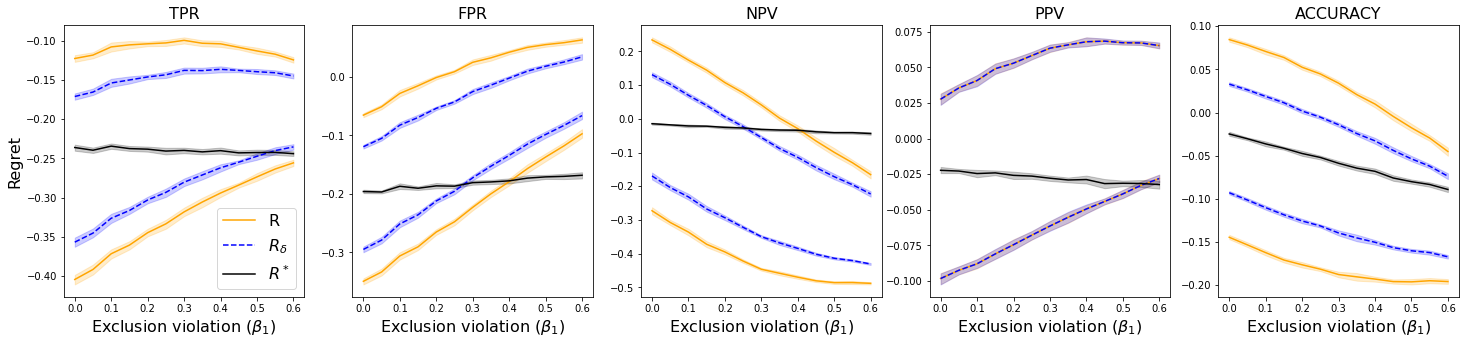

In [7]:
lambdas = np.arange(1, 2.6, .1)
Dx, Du = 5, 2
nD = Dx+Du

dgp = {
    'N': 20000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    't_coeffs': 4*np.random.rand(nD) - 3,
    'lambda_star': 1.7,
    'id_assumption': 'IV'
}

dgp = set_dgp_config(dgp, 'IV')
dgp['beta_zd'] = 1.25
beta_zy = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, .5, .55, .6]
bedf = experiments.exclusion_sensitivity_experiment(dgp, beta_zy, n_sims=20, est_method='plugin', K=5)
plot_exclusion_sensitivity(bedf)

# Experiment: Relevance violation tests

outcome regression error: 0.06824760059892879
propensitiy error: 0.049074306125713806
outcome regression error: 0.06868448442286533
propensitiy error: 0.04931754631080577
outcome regression error: 0.06846216492365213
propensitiy error: 0.04970538042965789
outcome regression error: 0.06705595438734767
propensitiy error: 0.049983216022735276
outcome regression error: 0.06686022031671669
propensitiy error: 0.04830704358876422
outcome regression error: 0.06536468060002483
propensitiy error: 0.049133010872390206
outcome regression error: 0.06498370644245755
propensitiy error: 0.048804204700062095
outcome regression error: 0.0666571887496362
propensitiy error: 0.04937744681874213
outcome regression error: 0.06561882667748063
propensitiy error: 0.04886659123875899
outcome regression error: 0.06562634593360213
propensitiy error: 0.049739069722970625
outcome regression error: 0.06717501659842362
propensitiy error: 0.048001137545002445
outcome regression error: 0.06656584472157129
propensitiy er

outcome regression error: 0.06478433973342589
propensitiy error: 0.04627073747384061
outcome regression error: 0.06586805664433795
propensitiy error: 0.046935776305874324
outcome regression error: 0.06607808634051994
propensitiy error: 0.04693522685820543
outcome regression error: 0.06489211870825648
propensitiy error: 0.0461937575445767
outcome regression error: 0.0650160245877055
propensitiy error: 0.04609210298917004
outcome regression error: 0.0654831251501617
propensitiy error: 0.04710365924755479
outcome regression error: 0.06755739334339014
propensitiy error: 0.049184378605014095
outcome regression error: 0.06621928854905565
propensitiy error: 0.04761417625166365
outcome regression error: 0.06430554612256875
propensitiy error: 0.046814070707313124
outcome regression error: 0.0652336407445634
propensitiy error: 0.046328474551815435
outcome regression error: 0.06623287162316166
propensitiy error: 0.047061877563202896
outcome regression error: 0.06653660206076172
propensitiy error:

outcome regression error: 0.06715590840634528
propensitiy error: 0.043371830389188244
outcome regression error: 0.06732510937589387
propensitiy error: 0.04359931015777097
outcome regression error: 0.06632848717571312
propensitiy error: 0.04292531793372886
outcome regression error: 0.06719456225760907
propensitiy error: 0.042873547803713975
outcome regression error: 0.06668962771178193
propensitiy error: 0.04317783715352635
outcome regression error: 0.06562115888122955
propensitiy error: 0.04382732047536598
outcome regression error: 0.06552500887339424
propensitiy error: 0.04338151720010684
outcome regression error: 0.06552630526511913
propensitiy error: 0.04367416847257293
outcome regression error: 0.06537126603857357
propensitiy error: 0.04283510067389015
outcome regression error: 0.06486014022341921
propensitiy error: 0.04311114541131415
outcome regression error: 0.06614715251523368
propensitiy error: 0.04326398863763586
outcome regression error: 0.06833609653785172
propensitiy error

outcome regression error: 0.06451780205999541
propensitiy error: 0.0385280849833854
outcome regression error: 0.06484811392738268
propensitiy error: 0.039198151582252344
outcome regression error: 0.0656233135861742
propensitiy error: 0.03874671853126407
outcome regression error: 0.06438337285680781
propensitiy error: 0.03833778477633692
outcome regression error: 0.0655929186388131
propensitiy error: 0.03861658555181829
outcome regression error: 0.06510781811212477
propensitiy error: 0.03855167883151423
outcome regression error: 0.06442737976090343
propensitiy error: 0.03789604433824311
outcome regression error: 0.06549231972411579
propensitiy error: 0.039120933581756744
outcome regression error: 0.06590785127596939
propensitiy error: 0.03930376173885446
outcome regression error: 0.06588809496888276
propensitiy error: 0.03777274905976745
outcome regression error: 0.06609093487467733
propensitiy error: 0.03893817349063522
outcome regression error: 0.06662298712411129
propensitiy error: 0

outcome regression error: 0.06533587316621489
propensitiy error: 0.034626055788293496
outcome regression error: 0.06625393462033628
propensitiy error: 0.033506603018997105
outcome regression error: 0.06598510159653002
propensitiy error: 0.03381793038152909
outcome regression error: 0.06525104019532975
propensitiy error: 0.03288346980408259
outcome regression error: 0.06601939775892172
propensitiy error: 0.03420828273679233
outcome regression error: 0.0650695409603367
propensitiy error: 0.032831373445561696
outcome regression error: 0.06473096984490279
propensitiy error: 0.033071325967555854
outcome regression error: 0.06799457301467425
propensitiy error: 0.03450359346634332
outcome regression error: 0.0658441701036937
propensitiy error: 0.034081288324940034
outcome regression error: 0.06668547526062352
propensitiy error: 0.03325471745085105
outcome regression error: 0.06701779486595087
propensitiy error: 0.03376889339395136
outcome regression error: 0.06646098050587633
propensitiy erro

outcome regression error: 0.06581689687492831
propensitiy error: 0.029669630417692765
outcome regression error: 0.06463505394911022
propensitiy error: 0.029346979886112626
outcome regression error: 0.06614345747522109
propensitiy error: 0.02839285057256346
outcome regression error: 0.06737241287403842
propensitiy error: 0.029555091902044375
outcome regression error: 0.06432293917511563
propensitiy error: 0.028498131483963553
outcome regression error: 0.06611782423547516
propensitiy error: 0.028289352369835895
outcome regression error: 0.06638430372341808
propensitiy error: 0.029367122232455748
outcome regression error: 0.06536032477238106
propensitiy error: 0.028284947191720505
outcome regression error: 0.06581947462997155
propensitiy error: 0.028573826969751116
outcome regression error: 0.06592311118573091
propensitiy error: 0.02873950359929387
outcome regression error: 0.06484169399558147
propensitiy error: 0.028693532594052905
outcome regression error: 0.06550755552205086
propensiti

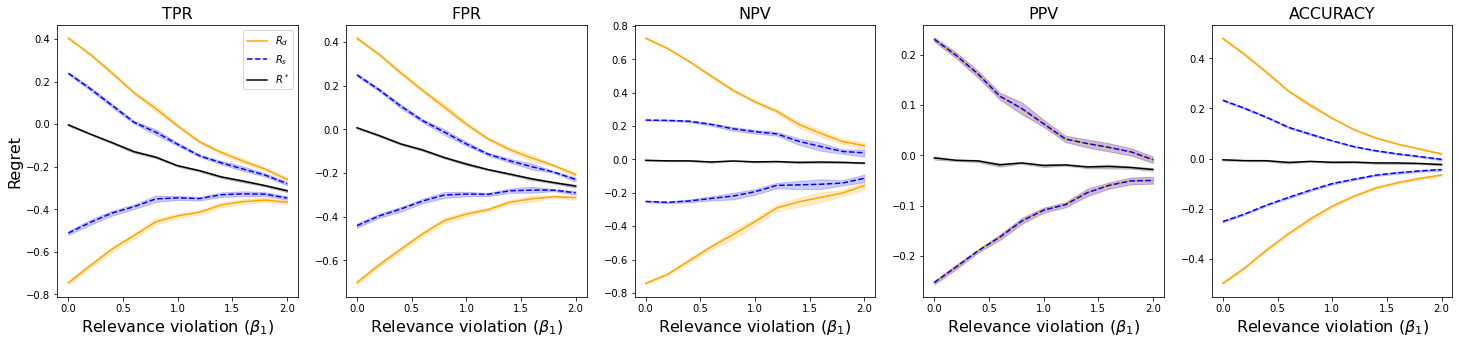

In [3]:
lambdas = np.arange(1, 2.6, .1)
Dx, Du = 5, 2
nD = Dx+Du

dgp = {
    'N': 20000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    't_coeffs': 4*np.random.rand(nD) - 3,
    'lambda': 1.5,
    'lambda_star': 1.7,
    'id_assumption': 'IV'
}

iv_dgp = set_dgp_config(dgp, 'IV')
beta_zd = [0, .2, .4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
brdf = experiments.relevance_sensitivity_experiment(iv_dgp, beta_zd, n_sims=10)



## Robustness check: MSM $\Lambda$ coverage

In [28]:
Nsims = 10
Dx, Du = 5, 2
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    't_coeffs': 4*np.random.rand(nD) - 3,
    'lambda': 1.4,
    'id_assumption': 'MSM'
}

msm_dgp = set_dgp_config(dgp, 'MSM')
lambda_star = [0, .2, .4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4]

msm_bounds = []

for ls in lambda_star:
    
    msm_dgp['lambda_star'] = ls
    
    for sim in range(Nsims):
        
        data = generate_data(msm_dgp)
        bounds = estimation.estimate_bounds(msm_dgp, data, id_method='MSM', est_method='plugin', K=5)
        bounds['ls'] = ls
        msm_bounds.append(bounds)

msmdf = pd.concat(msm_bounds)


outcome regression error: 0.08549464340329309
propensitiy error: 0.049029187430237334
outcome regression error: 0.08822013061844183
propensitiy error: 0.04850753936129217
outcome regression error: 0.08854845889604591
propensitiy error: 0.04965247546464513
outcome regression error: 0.09037595514194433
propensitiy error: 0.04902478227180549
outcome regression error: 0.0857147333286839
propensitiy error: 0.0492182038032904
outcome regression error: 0.08601531689499421
propensitiy error: 0.050016122753218456
outcome regression error: 0.087408516538992
propensitiy error: 0.049359005922241
outcome regression error: 0.08500032322624054
propensitiy error: 0.04877678810680359
outcome regression error: 0.0884402197489049
propensitiy error: 0.04849636858829813
outcome regression error: 0.08301924697572446
propensitiy error: 0.04862817821315876
outcome regression error: 0.08582207122923872
propensitiy error: 0.05025830450699422
outcome regression error: 0.0872635887039093
propensitiy error: 0.0499

outcome regression error: 0.08659467119759165
propensitiy error: 0.04792604421336182
outcome regression error: 0.0886972650602263
propensitiy error: 0.049610473582517835
outcome regression error: 0.08788467104338958
propensitiy error: 0.04843399158135503
outcome regression error: 0.08956911308663662
propensitiy error: 0.04773039440502795
outcome regression error: 0.08445216257461294
propensitiy error: 0.04862924531569587
outcome regression error: 0.0851280476490773
propensitiy error: 0.04810509528382983
outcome regression error: 0.08508127164284719
propensitiy error: 0.0488663583961854
outcome regression error: 0.08612221793642408
propensitiy error: 0.04936238947719006
outcome regression error: 0.08769254130320386
propensitiy error: 0.048768864784235554
outcome regression error: 0.08428391407804087
propensitiy error: 0.05055034634850514
outcome regression error: 0.08935788202701848
propensitiy error: 0.05160675313751227
outcome regression error: 0.08620231805921835
propensitiy error: 0

outcome regression error: 0.08514633449494573
propensitiy error: 0.049184192975654566
outcome regression error: 0.0883620266536892
propensitiy error: 0.04909544337853465
outcome regression error: 0.08625590495593108
propensitiy error: 0.05190234553277594
outcome regression error: 0.08619393493592067
propensitiy error: 0.0498160116750796
outcome regression error: 0.08693212849479659
propensitiy error: 0.04906141118673092
outcome regression error: 0.08459834855087982
propensitiy error: 0.0493986772866959
outcome regression error: 0.08781350147657165
propensitiy error: 0.050055302887923536
outcome regression error: 0.08251612326154989
propensitiy error: 0.047662435739158474
outcome regression error: 0.08405390257545223
propensitiy error: 0.049764433703862646
outcome regression error: 0.08276359909921878
propensitiy error: 0.04800114745338399
outcome regression error: 0.08131857211921176
propensitiy error: 0.047088301337217454
outcome regression error: 0.08255634834773083
propensitiy error

outcome regression error: 0.08638203396005832
propensitiy error: 0.050172095666178924
outcome regression error: 0.08453012650381302
propensitiy error: 0.05025260012634534
outcome regression error: 0.08439598893367761
propensitiy error: 0.049937706300998724
outcome regression error: 0.08446951073152868
propensitiy error: 0.051751981867324645
outcome regression error: 0.08535010529367719
propensitiy error: 0.048470273634463365
outcome regression error: 0.08856368092206998
propensitiy error: 0.05169359218014056
outcome regression error: 0.08627160026427382
propensitiy error: 0.04960451059246701
outcome regression error: 0.0851209301594064
propensitiy error: 0.049258660353328446
outcome regression error: 0.08635103642054683
propensitiy error: 0.05237903326399332
outcome regression error: 0.08599469321787577
propensitiy error: 0.05031336544573604
outcome regression error: 0.08673902959641282
propensitiy error: 0.05170159785963322
outcome regression error: 0.0860945700787173
propensitiy erro

outcome regression error: 0.08708358460648907
propensitiy error: 0.04932326130975409
outcome regression error: 0.0872446614547315
propensitiy error: 0.04924773942198552
outcome regression error: 0.08423638120147792
propensitiy error: 0.04739458172529358
outcome regression error: 0.08388533848479728
propensitiy error: 0.04812632936805998
outcome regression error: 0.08592426353926785
propensitiy error: 0.048096391981982345
outcome regression error: 0.0856526320098296
propensitiy error: 0.04721145618286746
outcome regression error: 0.0871275482430239
propensitiy error: 0.048031513625027736
outcome regression error: 0.08797470041400288
propensitiy error: 0.05142381186810765
outcome regression error: 0.08679395786988009
propensitiy error: 0.04942481900043837
outcome regression error: 0.08576838181640073
propensitiy error: 0.04804605417103558
outcome regression error: 0.08687336926611818
propensitiy error: 0.05035441252925347
outcome regression error: 0.08897547991203102
propensitiy error: 0

outcome regression error: 0.08610230759790084
propensitiy error: 0.04767422434845849
outcome regression error: 0.08813760381733994
propensitiy error: 0.04958218373814521
outcome regression error: 0.08950088837324484
propensitiy error: 0.048279289194776885
outcome regression error: 0.08840077833829647
propensitiy error: 0.05024436933462643
outcome regression error: 0.08728671146863845
propensitiy error: 0.050097990459876895
outcome regression error: 0.08887344163844042
propensitiy error: 0.05065764467692544
outcome regression error: 0.08407918772290116
propensitiy error: 0.049629627430680154
outcome regression error: 0.08911566441570283
propensitiy error: 0.05128640722606525
outcome regression error: 0.08817513023811031
propensitiy error: 0.05108209891561186
outcome regression error: 0.0878501064131375
propensitiy error: 0.04734447612131306
outcome regression error: 0.08509410738627123
propensitiy error: 0.04995387343192172
outcome regression error: 0.09017537118997071
propensitiy error

outcome regression error: 0.08641849576973869
propensitiy error: 0.049536657721456094
outcome regression error: 0.08597583771413204
propensitiy error: 0.049349095410582945
outcome regression error: 0.08712918438099314
propensitiy error: 0.05099818348416496
outcome regression error: 0.08764983791390887
propensitiy error: 0.050966430710907284
outcome regression error: 0.08739395325304526
propensitiy error: 0.05001288077044894
outcome regression error: 0.08835336370448488
propensitiy error: 0.05027977442538734
outcome regression error: 0.08869690506086561
propensitiy error: 0.05037986383355975
outcome regression error: 0.08932257647457881
propensitiy error: 0.04998444598349782
outcome regression error: 0.08510019135872471
propensitiy error: 0.048310158821285684
outcome regression error: 0.0887265723537968
propensitiy error: 0.05010261534320972
outcome regression error: 0.08521554213246466
propensitiy error: 0.049648389227098924
outcome regression error: 0.08426340935395879
propensitiy err

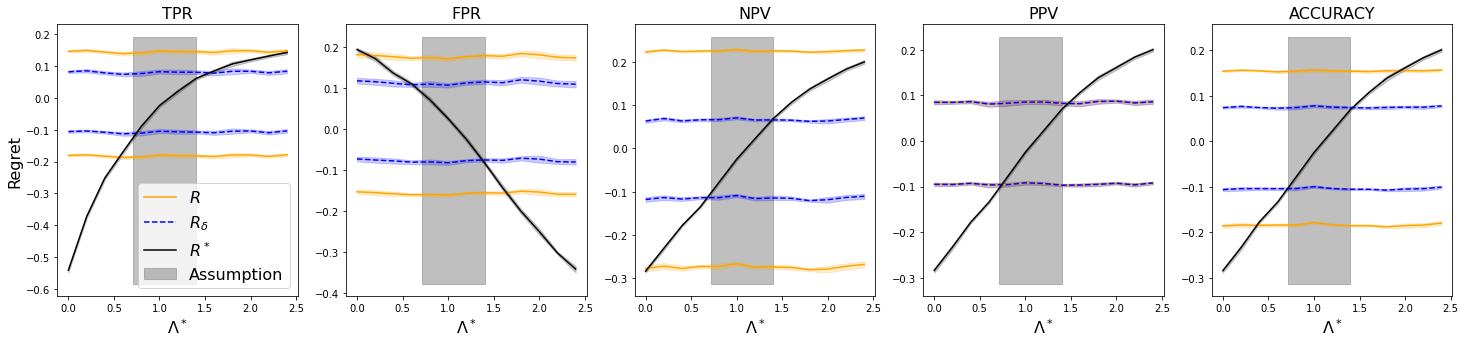

In [30]:
lam = msm_dgp['lambda']
metrics = msmdf['metric'].unique().tolist()

fig, axes = plt.subplots(1, 5, figsize=(25, 5)) # Adjust the figsize as needed

for i, metric in enumerate(metrics):
    
    # Filter the DataFrame for the current metric
    metric_df = msmdf[msmdf['metric'] == metric]
    
    # Reset the index to avoid the duplicate labels error
    metric_df = metric_df.reset_index(drop=True)
    ymin = metric_df[['Rs_down', 'Rs_up', 'Rd_down', 'Rd_up', 'R_oracle']].min().min()
    ymax = metric_df[['Rs_down', 'Rs_up', 'Rd_down', 'Rd_up', 'R_oracle']].max().max()
    
    # Create each lineplot on the corresponding subplot axis
    sns.lineplot(ax=axes[i], data=metric_df, x='ls', y='Rs_up', color='orange', linestyle='-', label='$R$')
    sns.lineplot(ax=axes[i], data=metric_df, x='ls', y='Rs_down', color='orange', linestyle='-')
    sns.lineplot(ax=axes[i], data=metric_df, x='ls', y='Rd_up', color='b', linestyle='--', label='$R_{\delta}$')
    sns.lineplot(ax=axes[i], data=metric_df, x='ls', y='Rd_down', color='b', linestyle='--')
    sns.lineplot(ax=axes[i], data=metric_df, x='ls', y='R_oracle', color='black', label='$R^*$')

    # Set the titles, labels, etc.
    axes[i].set_xlabel(r'$\Lambda^*$', fontsize=16)
    axes[i].set_title(f'{utils.metric_dict[metric]}', fontsize=16)
    axes[i].set_ylabel(f'', fontsize=16)
    
    ymin, ymax = axes[i].get_ylim()
    axes[i].fill_between([lam**-1, lam], ymin, ymax, color='grey',
                         alpha=0.5, zorder=-1, label='Assumption')
    axes[i].legend().set_visible(False)
    
axes[0].set_ylabel(f'Regret', fontsize=16)
axes[0].legend(fontsize=16)
plt.savefig('figs/msm_assumption.pdf', dpi=500, bbox_inches='tight')